## PSF Modeling

PSF modeling with *SExtractor* and *PSFExtractor* consists of three steps:

- Preprocessing: It requires decompressing the CompImageHDU with the image and then store it in uncompressed (.fits) format for further processing. HDUs 2 and 3 corresponding to Image mask and weights, respectively, do not seem to interact well with PSFExtractor, and so I only keep HDU 1 (the actual image) and HDU 0 (metadata).

- SExtractor: Run *SExtractor* software with *config.sex* for configuration parameters and *config.param* for the output parameters. The parameter file name is specified in *config.sex*, and so the command for running it looks like:

                source-extractor path/to/uncompressed-image.fits -c config.sex

- PSFExtractor: Run *PSFExtractor* with the values in *config.psfex*. Running it looks like this:

                psfex path/to/sextractor-catalog.cat - config.psf

Both parameters and parameter values are obtained from: https://arxiv.org/pdf/1801.03177.

I have also added a small subsection on postprocessing, where I draw a small image from the resulting PSF. Hope it's useful.

## Preprocessing

In [22]:
from astropy.io import fits

# Open the original FITS file with compressed HDUs
filepath = '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/'
compressed_filename = 'DES0000+0209_r4907p01_r_nobkg.fits.fz'
uncompressed_filename = 'DES0000+0209_r4907p01_r_nobkg_decompressed.fits'
save_hdu = 1

with fits.open(filepath + compressed_filename) as hdul:
    # Create a new HDUList to store the decompressed HDUs
    decompressed_hdul = fits.HDUList()
    
    # Loop over each HDU in the original file
    for (i,hdu) in enumerate(hdul):
        # Check if the HDU is a compressed image and decompress it
        if isinstance(hdu, fits.CompImageHDU):
            decompressed_data = hdu.data  # Access the decompressed data
            decompressed_header = hdu.header  # Copy the header
            # Create a new ImageHDU with the decompressed data
            new_hdu = fits.ImageHDU(data=decompressed_data, header=decompressed_header)
            decompressed_hdul.append(new_hdu)
            # Exit after the HDU 1, in this case.
            if i == save_hdu:
                break
        else:
            # If it's not a compressed HDU, just copy it over
            decompressed_hdul.append(hdu)
        

    # Save the decompressed file
    decompressed_hdul.writeto(filepath + uncompressed_filename, overwrite=True)


## Postprocessing

In [1]:
# The Galsim Des module must be imported separately from Galsim
import galsim.des

In [15]:
# The docs are useful here: https://galsim-developers.github.io/GalSim/_build/html/_modules/galsim/des/des_psfex.html
# The main docstring contains a discussion on coordinate systems, WCS vs. Image coordinates... probably important for us.
des_psfex=galsim.des.DES_PSFEx("../psfextraction/test.psf")
image_x, image_y = 100, 100
image_pos = galsim.PositionD(image_x, image_y)
psf = des_psfex.getPSF(image_pos)
psf_array = des_psfex.getPSFArray(image_pos)
# psf here is an interpolated image.

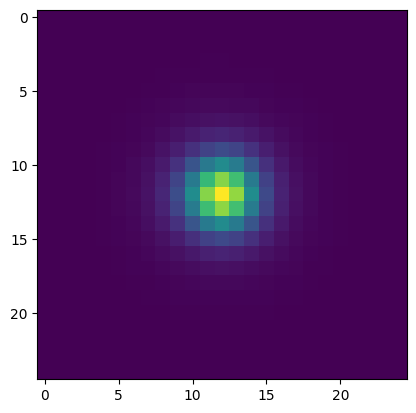

In [16]:
import matplotlib.pyplot as plt
plt.imshow(psf_array)